In [ ]:
!pip install pmdarima
!pip install yfinance


/tmp/ipython-input-1674958650.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Mean Squared Error (MSE): 13.0124
Root Mean Squared Error (RMSE): 3.6073
Mean Absolute Percentage Error (MAPE): 1.15%
R-squared (R²): 0.9824


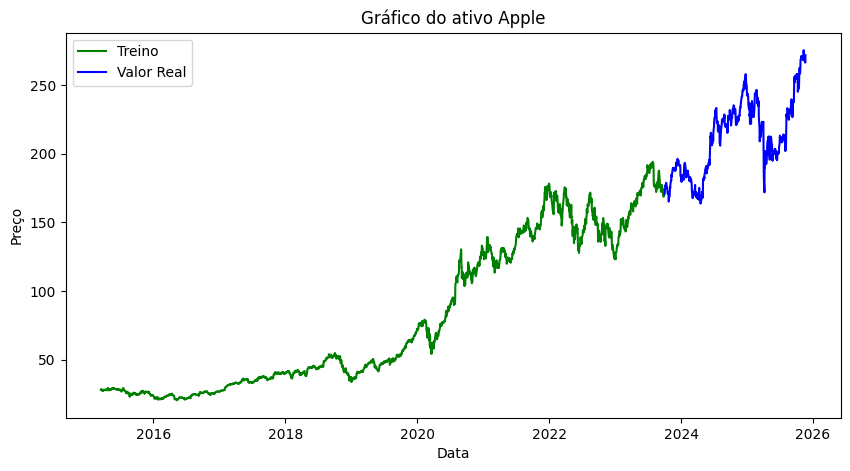

In [ ]:
# 1 -> Regressão linear

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import yfinance as yf


#escolha do ativo, período dos dados coletados e 'download' desses dados
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2025-11-22'
data = yf.download(ticker, start=start_date, end=end_date)

#tratamento de cabeçalho do yfinance, que as vezes vem com colunas com mais de um index
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

#criação das medias móveis simples de 20 e 50 dias
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()

#define o alvo e tenta prever o fechamento do dia seguinte usando os preços do dia atual
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_20', 'SMA_50']
data['Target_Next_Close'] = data['Close'].shift(-1)
dados_futuros = data.iloc[[-1]][features]
data.dropna(inplace=True)

#atributos(X) e alvo(Y)
X = data[features]
y = data['Target_Next_Close']

#divisão dos dados em treino(80 porcento) e teste (20 porcento)
train_size = int(len(data) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

#modelo
model = LinearRegression()
model.fit(X_train, y_train)

#previsão do modelo
y_pred = model.predict(X_test)

#parâmetros de avaliação desses modelos
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred) # Média dos erros
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred) # o quão bem o modelo explica a variação dos dados

#métricas de comparação
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")
print(f"R-squared (R²): {r2:.4f}")

#pega o ultimo dia de dados, que foi salvo acima e tenta prever o ultimo fechamento real
last_known_data = X.iloc[[-1]]
predicted_tomorrow = model.predict(dados_futuros)

plt.figure(figsize=(10, 5))
plt.plot(y_train.index, y_train, label='Treino', color='green')
plt.plot(y_test.index, y_test, label='Valor Real', color='blue')
#plt.plot(y_test.index, y_pred, label='Previsão do Modelo', color='red', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.title('Gráfico do ativo Apple')
plt.legend()
plt.show()

/tmp/ipython-input-33282109.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Mean Squared Error (MSE): 17.6026
Root Mean Squared Error (RMSE): 4.1956
Mean Absolute Percentage Error (MAPE): 1.26%
R-squared (R²): 0.9624


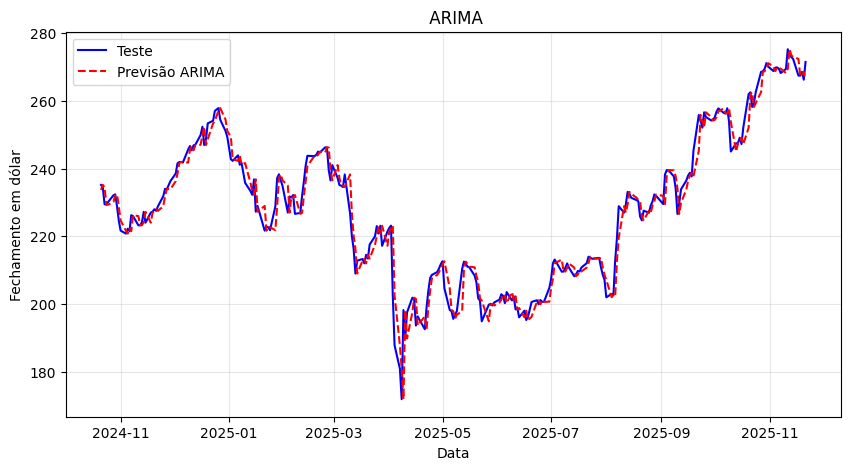

In [ ]:
# 2 -> ARIMA -- AutoRegressive Integrated Moving Average

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2025-11-22'
data = yf.download(ticker, start=start_date, end=end_date)

if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

df = data[['Close']].dropna() #selecionamos apenas a coluna Close para tratamento de dados, os outros atributos não são necessários

train_size = int(len(df) * 0.9)
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

#escolhe o melhor p,d e q para o nosso modelo, onde
# p é o autoregressive (quantos dias para trás afetam o dia atual)
# d é o Integrated (qts vezes vamos subtrair o dia atual para tornar o gráfico estável)
# q é o Moving Average (tamanho da janela de erro da média móvel)
model_auto = auto_arima(train_data, start_p=0, start_q=0, max_p=5, max_q=5, d=1, seasonal=False, suppress_warnings=True)
best_order = model_auto.order

history = [x for x in train_data['Close']]
predictions = []
reais = test_data['Close'].values

#treinamento utilizando os dados até o dia anterior para prever o preço do dia atual
#pega o valor real e depois adiciona ao histórico para tentar prever o próximo dia
for t in range(len(test_data)):
    model = ARIMA(history, order=best_order)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = reais[t]
    history.append(obs)

predicted_series = pd.Series(predictions, index=test_data.index)

#Padronização das métricas
rmse = np.sqrt(mean_squared_error(test_data['Close'], predicted_series))
mse = mean_squared_error(test_data['Close'], predicted_series)
mape = mean_absolute_percentage_error(test_data['Close'], predicted_series)
r2 = r2_score(test_data['Close'], predicted_series)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")
print(f"R-squared (R²): {r2:.4f}")

plt.figure(figsize=(10, 5))
#plt.plot(train_data.index, train_data['Close'], label='Treino', color='green', alpha=0.5)
plt.plot(test_data.index, test_data['Close'], label='Teste', color='blue', linewidth=1.5)
plt.plot(test_data.index, predicted_series, label='Previsão ARIMA', color='red', linestyle='--', linewidth=1.5)
plt.title(' ARIMA')
plt.xlabel('Data')
plt.ylabel('Fechamento em dólar')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.0266 - val_loss: 6.7469e-04
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 9.1027e-04 - val_loss: 9.2370e-04
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 8.0756e-04 - val_loss: 0.0013
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 7.1361e-04 - val_loss: 3.6340e-04
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 6.1413e-04 - val_loss: 8.2603e-04
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 6.0343e-04 - val_loss: 0.0013
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 6.1328e-04 - val_loss: 7.6656e-04
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 5.6061e-04 - val_loss: 0.0018
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 5.6511e-04 - val_loss: 4.3385e-04
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 5.5600e-04 - val_loss: 4.9060e-04


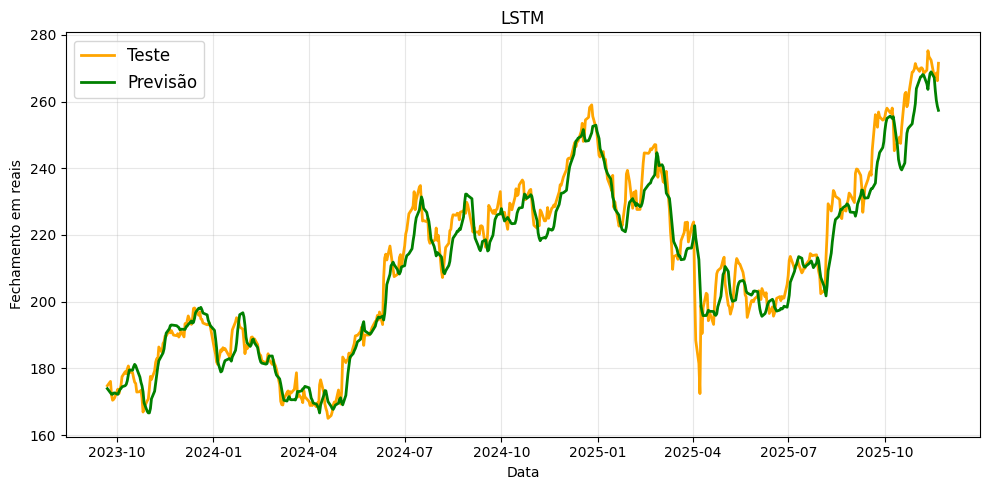

In [ ]:
#3 --> LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import math

ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2025-11-22'
df = yf.download(ticker, start=start_date, end = end_date ,auto_adjust=False, progress=False)

if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df = df[['Close']]
df.columns = ['Close']
target_col = 'Close'

#assim como o Close, define SMA_14 (Media Móvel simples de 14 dias) e RSI
# (Índice de força relativa) como atributos para serem utilizados
df['SMA_14'] = df[target_col].rolling(window=14).mean()
delta = df[target_col].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))
df.dropna(inplace=True)
features = [target_col, 'SMA_14', 'RSI']
dataset = df[features].values
num_features = len(features)

#Faz a normalização para os valores ficarem entre 0 e 1, porque normalemente
#estão em escalas diferentes ou os valores são muito grandes
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaler_target.fit(dataset[:, 0].reshape(-1, 1))

#cria uma janela de tempo de 60 dias
look_back = 60
training_data_len = math.ceil(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]
test_data = scaled_data[training_data_len - look_back:, :]

def create_dataset(dataset, look_back):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, :])
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train_data, look_back)
x_test, y_test = create_dataset(test_data, look_back)
x_train = np.reshape(x_train, (x_train.shape[0], look_back, num_features))
x_test = np.reshape(x_test, (x_test.shape[0], look_back, num_features))

#modelo LSTM
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(look_back, num_features)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=32))
model.add(Dense(units=1))

#define uma parada antecipada caso o modelo pare de melhorar por 15 épocas seguidas
#no patiente = 15
model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=100,
                    validation_split=0.1,
                    callbacks=[early_stop],
                    verbose=1)

#previsão e desnormalização
predictions_scaled = model.predict(x_test)
predictions = scaler_target.inverse_transform(predictions_scaled)
num_predictions = len(predictions)
valid_set = df.iloc[-num_predictions:].copy()
valid_set['Predictions'] = predictions
train_set = df.iloc[:-num_predictions]

#Padronização de métricas
y_real = valid_set[target_col]
y_pred = valid_set['Predictions']
rmse = np.sqrt(mean_squared_error(y_real, y_pred))
mse = mean_squared_error(y_real, y_pred)
mape = mean_absolute_percentage_error(y_real, y_pred)
r2 = r2_score(y_real, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")
print(f"R-squared (R²): {r2:.4f}")


plt.figure(figsize=(10,5))
plt.title('LSTM')
plt.xlabel('Data')
plt.ylabel('Fechamento em reais')
#plt.plot(train_set.index, train_set[target_col], label='Treino')
plt.plot(valid_set.index, valid_set[target_col], label='Teste', color='orange', linewidth=2)
plt.plot(valid_set.index, valid_set['Predictions'], label='Previsão', color='green', linewidth=2)
plt.legend(loc='best', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Treinando modelo nos RETORNOS...
Epoch 1/100


/tmp/ipython-input-2866066798.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.0204 - val_loss: 0.0112
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.0189 - val_loss: 0.0111
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0178 - val_loss: 0.0112
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.0174 - val_loss: 0.0110
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0159 - val_loss: 0.0111
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.0187 - val_loss: 0.0111
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0193 - val_loss: 0.0117
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.0192 - val_loss: 0.0112
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - loss: 0.0166 - val_loss: 0.0110
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.0190 - val_loss: 0.0110
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0177 - val_loss: 0.0110
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - 

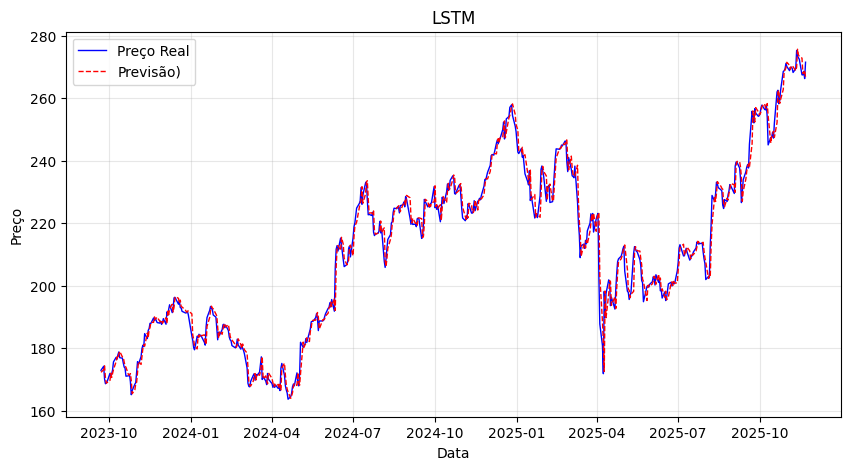

In [ ]:
# 4 - LSTM para comparar retornos ==> variação do ativo

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import math

ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2025-11-22'

# Download dos dados
df = yf.download(ticker, start=start_date, end=end_date, progress=False)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df = df[['Close']]
df.columns = ['Close']

# Calculo de retornos
# Retorno = (Preço Hoje - Preço Ontem) / Preço Ontem
df['Return'] = df['Close'].pct_change()
df['Return_SMA_14'] = df['Return'].rolling(window=14).mean()

# Limpar not an numbee
df.dropna(inplace=True)

target_col = 'Return'
features = ['Return', 'Return_SMA_14']

dataset = df[features].values
num_features = len(features)

# normalização
# Como os retornos podem ser negativos também, o range da normalização ficou entre -1 e 1
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(dataset)

scaler_target = MinMaxScaler(feature_range=(-1, 1))
scaler_target.fit(df[[target_col]])

look_back = 60
training_data_len = math.ceil(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]
test_data = scaled_data[training_data_len - look_back:, :]

def create_dataset(dataset, look_back):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, :])
        Y.append(dataset[i, 0]) # previsão do próximo retorno
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train_data, look_back)
x_test, y_test = create_dataset(test_data, look_back)

x_train = np.reshape(x_train, (x_train.shape[0], look_back, num_features))
x_test = np.reshape(x_test, (x_test.shape[0], look_back, num_features))

model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(look_back, num_features)))
model.add(Dropout(0.3))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

print("Treinando modelo nos RETORNOS...")
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=100,
                    validation_split=0.1,
                    callbacks=[early_stop],
                    verbose=1)

predicted_returns_scaled = model.predict(x_test)
predicted_returns = scaler_target.inverse_transform(predicted_returns_scaled)

test_indices = df.index[training_data_len:]
real_prices = df['Close'].iloc[training_data_len:].values

previous_prices = df['Close'].iloc[training_data_len-1 : -1].values

predicted_prices = previous_prices * (1 + predicted_returns.flatten())

#métricas
rmse = np.sqrt(mean_squared_error(real_prices, predicted_prices))
mse = mean_squared_error(real_prices, predicted_prices)
mape = mean_absolute_percentage_error(real_prices, predicted_prices)
r2 = r2_score(real_prices, predicted_prices)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")
print(f"R-squared (R²): {r2:.4f}")

plt.figure(figsize=(10,5))
plt.title('LSTM')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.plot(test_indices, real_prices, label='Preço Real', color='blue', linewidth=1)
plt.plot(test_indices, predicted_prices, label='Previsão)', color='red', linestyle='--', linewidth=1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

/tmp/ipython-input-2417759735.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, progress=False)


Mean Squared Error (MSE): 14.6962
Root Mean Squared Error (RMSE): 3.8336
Mean Absolute Percentage Error (MAPE): 1.23%
R-squared (R²): 0.9803


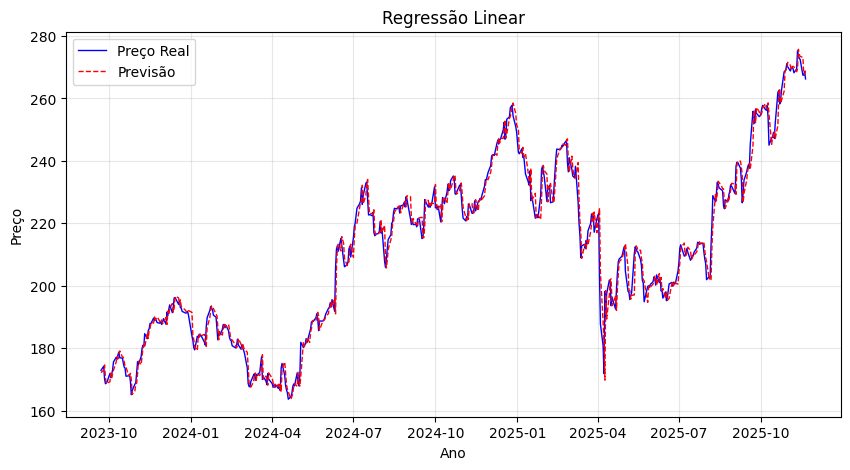

In [ ]:
# 5 - Regressão Linear aplicado a variação

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import yfinance as yf

ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2025-11-22'
data = yf.download(ticker, start=start_date, end=end_date, progress=False)

if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data = data[['Close']]
data['Return'] = data['Close'].pct_change()

data['Return_SMA_20'] = data['Return'].rolling(window=20).mean()
data['Return_Lag1'] = data['Return'].shift(1)
data['Target_Next_Return'] = data['Return'].shift(-1)

data.dropna(inplace=True)

# Atributos (X) e Alvo (y)
features = ['Return', 'Return_Lag1', 'Return_SMA_20']
X = data[features]
y = data['Target_Next_Return']

# Divisão Treino/Teste
train_size = int(len(data) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Previsão (em %)
y_pred_returns = model.predict(X_test)
test_indices = data.index[train_size:]

raw_prices_test = data['Close'].iloc[train_size:]
prev_prices = data['Close'].shift(1).iloc[train_size:]

price_predicted = prev_prices * (1 + y_pred_returns)
price_real = raw_prices_test

# métricas
rmse = np.sqrt(mean_squared_error(price_real, price_predicted))
mse = mean_squared_error(price_real, price_predicted)
mape = mean_absolute_percentage_error(price_real, price_predicted)
r2 = r2_score(price_real, price_predicted)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")
print(f"R-squared (R²): {r2:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(test_indices, price_real, label='Preço Real', color='blue', linewidth=1)
plt.plot(test_indices, price_predicted, label='Previsão', color='red', linestyle='--', linewidth=1)
plt.title('Regressão Linear')
plt.xlabel('Ano')
plt.ylabel('Preço')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()